In [21]:
import csv
%matplotlib inline
from pylab import *
rcParams['figure.figsize'] = (16,9)
rcParams['font.size'] = 12
import numpy as np
import scipy as sp
import os 
import glob
import pandas as pd
import seaborn as sns

#pd.set_option("display.max_rows", None, "display.max_columns", None)

data_path = os.getcwd()
data_extension = "csv"

os.chdir(data_path)

In [22]:
result = [file for file in glob.glob("/home/juergen/Desktop/logs_phase1/" + '*.{}'.format(data_extension))]
print(result)

['/home/juergen/Desktop/logs_phase1/0-1-f.csv', '/home/juergen/Desktop/logs_phase1/0-cooldown-f.csv', '/home/juergen/Desktop/logs_phase1/0-2-f.csv', '/home/juergen/Desktop/logs_phase1/0-5-f.csv', '/home/juergen/Desktop/logs_phase1/0-4-f.csv', '/home/juergen/Desktop/logs_phase1/0-0-f.csv', '/home/juergen/Desktop/logs_phase1/0-3-f.csv', '/home/juergen/Desktop/logs_phase1/0-warmup-f.csv']


In [23]:
dff = [pd.read_csv(f, delimiter = ',') for f in result]

concats = {}

for df in dff:
    condition_id = list(df["condition_id"])[0]
    
    if not condition_id in concats:
        concats[condition_id] = df
    else:
        concats[condition_id] = pd.concat([concats[condition_id], df])
        
dff = concats.values()

pids = list(concats[0].pid.unique())

In [24]:
import math

class Run:
    def __init__(self, data):
        self.data = data
                
        self.condition = list(data["condition_id"])[0]
        
        self.pid = list(data["pid"])[-1]        
        self.run_id = list(data["run_id"])[-1]
        self.run_starttime = list(data["timestampConditionStart"])[-1]
        
        self.successful_click_time = list(data["timestampClick"])[0]
        
        self.errors = -1
    
        for i in list(data["timestampClick"]):
            if self.successful_click_time != i:
                self.errors += 1
                self.successful_click_time = i
                
        self.run_duration = self.successful_click_time - self.run_starttime
        
        ###########################
        self.collisions = 0
        initial_collision_ts = list(data["timestampCollision"])[0]

        for i in list(data["timestampCollision"]):
            if initial_collision_ts != i:
                self.collisions += 1
                initial_collision_ts = i
                
        self.run_duration = self.successful_click_time - self.run_starttime
        
        
        ##############################
       
        self.num_cursor_movements = 0
        self.cursor_movement_length = 0
        self.num_target_movements = 0
        self.target_movement_length = 0
        
        initial_cursor_x = int(float(list(data["cursorX"])[0]))
        initial_cursor_y = int(float(list(data["cursorY"])[0]))
        initial_target_x = int(float(list(data["targetX"])[0]))
        initial_target_y = int(float(list(data["targetY"])[0]))
        
        for i in range(0, len(list(data["cursorX"]))):
            x, y = int(float(list(data["cursorX"])[i])), int(float(list(data["cursorY"])[i]))
            tx, ty = int(float(list(data["targetX"])[i])), int(float(list(data["targetY"])[i]))
            
            if x != initial_cursor_x or y != initial_cursor_y:
                self.cursor_movement_length += self.vector_length(x - initial_cursor_x, y - initial_cursor_y)
                self.num_cursor_movements += 1
                initial_cursor_x = x
                initial_cursor_y = y
                
            if tx != initial_target_x or ty != initial_target_y:
                self.num_target_movements += 1
                self.target_movement_length += self.vector_length(tx - initial_target_x, ty - initial_target_y)
                initial_target_x = tx
                initial_target_y = ty
              
    def __repr__(self):
        return "condition:{0}\npid: {1}\nrun_id: {2}\ncollisions:{3}\nerrors:{4}\nduration:{5} ms\ncursor movements:{6}\ncursor movement length:{7}\ntarget movements:{8}\ntarget movement length:{9}\n\n".format(
            self.condition,
            self.pid,
            self.run_id,
            self.collisions,
            self.errors,
            self.run_duration,
            self.num_cursor_movements,
            self.cursor_movement_length,
            self.num_target_movements,
            self.target_movement_length)
    
    def vector_length(self, u, v):
        return math.sqrt(u * u + v * v)
    

In [25]:
conditions = []

for df in dff:
    conditions.append([])
    
    for pid in pids:
        dfp = df[df["pid"] == pid]
        
        for rid in range(1, max(df["run_id"])):
            dfpr = dfp[dfp["run_id"] == rid]
            
            conditions[-1].append(Run(dfpr))

# Results

## Duration

condition: Factor 0.25 MUI has mean duration of -32643.770833333332 ms
condition: Factor 0.25 MUI has median duration of -32713.5 ms

condition: Cooldown has mean duration of -217214.30434782608 ms
condition: Cooldown has median duration of -217611.0 ms

condition: Factor 0.5 MUI has mean duration of -111458.9375 ms
condition: Factor 0.5 MUI has median duration of -111494.5 ms

condition: Static UI with 1.5x CD Gain has mean duration of -72684.20833333333 ms
condition: Static UI with 1.5x CD Gain has median duration of -72863.0 ms

condition: Factor 0.1 MUI has mean duration of -148641.0 ms
condition: Factor 0.1 MUI has median duration of -148859.0 ms

condition: Static UI has mean duration of -2254.3958333333335 ms
condition: Static UI has median duration of 579.5 ms

condition: Factor 0.75 MUI has mean duration of -186077.66666666666 ms
condition: Factor 0.75 MUI has median duration of -185925.5 ms

condition: Warmup has mean duration of 707.5652173913044 ms
condition: Warmup has med

([<matplotlib.axis.XTick at 0x7fd0df3334c0>,
 [Text(1, 0, 'Factor 0.25 MUI'),
  Text(2, 0, 'Factor 0.5 MUI'),
  Text(3, 0, 'Static UI with 1.5x CD Gain'),
  Text(4, 0, 'Factor 0.1 MUI'),
  Text(5, 0, 'Static UI'),
  Text(6, 0, 'Factor 0.75 MUI')])

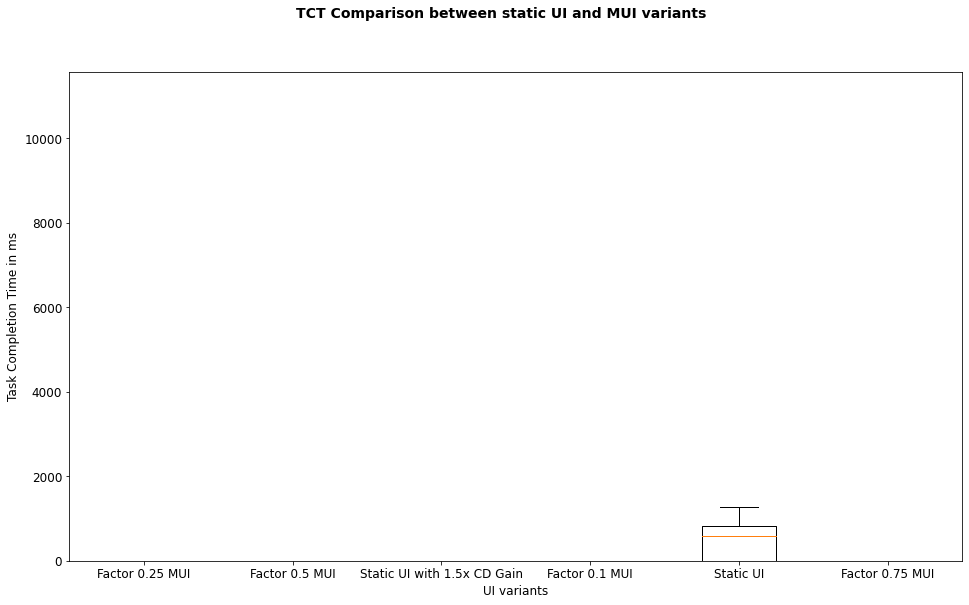

In [26]:
durations = {}

for condition in conditions:
    durations[condition[0].condition] = [run.run_duration for run in condition]
        
ticks = []
data = []

for condition, duration_measurements in durations.items(): 
    cond_name = "Warmup" if condition == -1 else "Static UI" if condition == 0 else "Factor 0.25 MUI" if condition == 1 else "Factor 0.5 MUI" if condition == 2 else "Factor 0.75 MUI" if condition == 3 else "Factor 0.1 MUI" if condition == 4  else "Static UI with 1.5x CD Gain" if condition == 5 else "Cooldown"
    
    print("condition: {0} has mean duration of {1} ms".format(cond_name, np.mean(duration_measurements)))
    print("condition: {0} has median duration of {1} ms".format(cond_name, np.median(duration_measurements)))
    print()
    
    if cond_name != "Warmup" and cond_name != "Cooldown":
        data.append(duration_measurements)
        ticks.append(cond_name)

fig = plt.figure()
fig.suptitle('TCT Comparison between static UI and MUI variants', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(data)
ax.set_xlabel('UI variants')
ax.set_ylabel('Task Completion Time in ms')
ax.set_ylim(bottom=0)
xticks([i + 1 for i in range(len(ticks))], ticks)


In [7]:
from scipy.stats import ttest_rel as ttest

static_durations = durations[0]
factor025_durations = durations[1]
factor05_durations = durations[2]
factor075_durations = durations[3]
factor1_durations = durations[4]
static15cdg_durations = durations[5]

def getConditionName(cond):
    cond_name = "Static UI" if cond == 0 else "Factor 0.25 MUI" if cond == 1 else "Factor 0.5 MUI" if cond == 2 else "Factor 0.75 MUI" if cond == 3 else "Factor 0.1 MUI" if cond == 4  else "Static UI with 1.5x CD Gain"
    return cond_name
    
for cond in range(6):
    cond_name = getConditionName(cond)
    for condToCompare in range(6):
        if cond != condToCompare:
            condToCompare_name = getConditionName(condToCompare)
            print(cond_name + " vs " + condToCompare_name + " -> p = {}".format(ttest(durations[cond], durations[condToCompare])[1]))
    print()

Static UI vs Factor 0.25 MUI -> p = 0.43422088847256746
Static UI vs Factor 0.5 MUI -> p = 0.7611734064281968
Static UI vs Factor 0.75 MUI -> p = 0.14115237802172262
Static UI vs Factor 0.1 MUI -> p = 0.6534477951068158
Static UI vs Static UI with 1.5x CD Gain -> p = 0.1695528364606544

Factor 0.25 MUI vs Static UI -> p = 0.43422088847256746
Factor 0.25 MUI vs Factor 0.5 MUI -> p = 0.4183291565063665
Factor 0.25 MUI vs Factor 0.75 MUI -> p = 0.12978812759549052
Factor 0.25 MUI vs Factor 0.1 MUI -> p = 0.3538489996906992
Factor 0.25 MUI vs Static UI with 1.5x CD Gain -> p = 0.9915962470664179

Factor 0.5 MUI vs Static UI -> p = 0.7611734064281968
Factor 0.5 MUI vs Factor 0.25 MUI -> p = 0.4183291565063665
Factor 0.5 MUI vs Factor 0.75 MUI -> p = 0.2147730357833594
Factor 0.5 MUI vs Factor 0.1 MUI -> p = 0.8305417423220436
Factor 0.5 MUI vs Static UI with 1.5x CD Gain -> p = 0.16320871539644718

Factor 0.75 MUI vs Static UI -> p = 0.14115237802172262
Factor 0.75 MUI vs Factor 0.25 MUI ->

## Errors

In [8]:
def increase_in_percent(counter, denominator):
    return (counter / (denominator / 100)) - 100

errors = {}

for condition in conditions:
    errors[condition[0].condition] = sum([run.errors for run in condition])

for cond in range(6):
    cond_name = getConditionName(cond)
    print("Errors for " + cond_name + ": {}".format(errors[cond]))
    for condToCompare in range(6):
        if cond != condToCompare:
            condToCompare_name = getConditionName(condToCompare)
            print(cond_name + " vs " + condToCompare_name + " -> {}%".format(increase_in_percent(errors[cond], errors[condToCompare])))
    print("")

Errors for Static UI: 0
Static UI vs Factor 0.25 MUI -> -100.0%
Static UI vs Factor 0.5 MUI -> -100.0%
Static UI vs Factor 0.75 MUI -> -100.0%
Static UI vs Factor 0.1 MUI -> -100.0%
Static UI vs Static UI with 1.5x CD Gain -> -100.0%

Errors for Factor 0.25 MUI: 5
Factor 0.25 MUI vs Static UI -> inf%
Factor 0.25 MUI vs Factor 0.5 MUI -> 66.66666666666669%
Factor 0.25 MUI vs Factor 0.75 MUI -> 400.0%
Factor 0.25 MUI vs Factor 0.1 MUI -> 150.0%
Factor 0.25 MUI vs Static UI with 1.5x CD Gain -> 66.66666666666669%

Errors for Factor 0.5 MUI: 3
Factor 0.5 MUI vs Static UI -> inf%
Factor 0.5 MUI vs Factor 0.25 MUI -> -40.0%
Factor 0.5 MUI vs Factor 0.75 MUI -> 200.0%
Factor 0.5 MUI vs Factor 0.1 MUI -> 50.0%
Factor 0.5 MUI vs Static UI with 1.5x CD Gain -> 0.0%

Errors for Factor 0.75 MUI: 1
Factor 0.75 MUI vs Static UI -> inf%
Factor 0.75 MUI vs Factor 0.25 MUI -> -80.0%
Factor 0.75 MUI vs Factor 0.5 MUI -> -66.66666666666666%
Factor 0.75 MUI vs Factor 0.1 MUI -> -50.0%
Factor 0.75 MUI vs S

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


## Covered Distances

In [9]:
# covered_distance
mean_covered_distances_cursor = {}

for condition in conditions:
    mean_covered_distances_cursor[condition[0].condition] = sum([run.cursor_movement_length for run in condition]) / len([run.cursor_movement_length for run in condition])

In [10]:
static_mean_covered_distance = mean_covered_distances_cursor[0]
factor05_mean_covered_distance = mean_covered_distances_cursor[1]
factor1_mean_covered_distance = mean_covered_distances_cursor[2]
static15cdg_mean_covered_distance = mean_covered_distances_cursor[3]


for cond in range(6):
    cond_name = getConditionName(cond)
    print("Mean covered distance of cursor for " + cond_name + ": {}px".format(mean_covered_distances_cursor[cond]))

Mean covered distance of cursor for Static UI: 344.06519166676276px
Mean covered distance of cursor for Factor 0.25 MUI: 314.7779124525265px
Mean covered distance of cursor for Factor 0.5 MUI: 260.5311398300616px
Mean covered distance of cursor for Factor 0.75 MUI: 217.98997767314518px
Mean covered distance of cursor for Factor 0.1 MUI: 263.2250370725401px
Mean covered distance of cursor for Static UI with 1.5x CD Gain: 464.77631956094683px


## Most notable observation

WIP